### Import Required Libraries

In [2]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

### Read Data

El dataset son dos archivos: una transcripción en ingles del parlamento europeo y una traducción al francés.

In [2]:
# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt')#, encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text

In [3]:
data_en = read_text("data_traductor/en.txt").split("\n")
data_fr = read_text("data_traductor/fr.txt").split("\n")

In [4]:
print(len(data_en))
print(len(data_fr))

947970
947970


Nos quedamos solo con la parte anterior a los signos de puntuación mas comunes [, . ? ! : (]

In [5]:
data_en = data_en[:50000]
data_fr = data_fr[:50000]

regex = "^(.*?)(,|\.|\?|!|:|\()"

data_en = [
    re.findall(regex, txt)[0][0]
    if re.findall(regex, txt)
    else txt
    for txt in data_en 
]

data_fr = [
    re.findall(regex, txt)[0][0]
    if re.findall(regex, txt)
    else txt
    for txt in data_fr
]

In [6]:
data_en[110:130]

['The list of candidates on this ballot has been placed in each polling station',
 'The Clerk is unsealing the ballots and the polling booths are now open',
 'The polling booths are now open',
 '',
 'The Presiding Officer',
 'If there are any hon',
 'I now instruct the Clerk to proceed with the counting of the ballots after I have cast my ballot',
 'SUSPENSION OF SITTING ',
 'The Presiding Officer ',
 'Before suspending the sitting',
 '',
 'SITTING RESUMED ',
 'The House resumed at 3',
 '',
 'The Presiding Officer ',
 'It is my duty to inform the House that the Speaker of this House has been duly elected',
 'It is now my great pleasure to invite the hon',
 'Some hon',
 'Hear',
 'The Presiding Officer']

In [7]:
en_fr = array([data_en,data_fr]).transpose()

### Text Pre-Processing

We will get rid of the punctuation marks (las que queden), and then convert the text to lower case.

In [8]:
# Remove punctuation
en_fr[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in en_fr[:,0]]
en_fr[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in en_fr[:,1]]

In [9]:
en_fr

array([['EDITED HANSARD  NUMBER 1 ', 'HANSARD RÉVISÉ  NUMÉRO 1 '],
       ['Monday', 'Le lundi 22 septembre 1997 '],
       ['FIRST SESSION36TH PARLIAMENT ',
        'PREMIÈRE SESSION36E LÉGISLATURE '],
       ...,
       ['In Canada',
        'Le cheminement canadien est peutêtre moins spectaculaire'],
       ['Eventually', 'Éventuellement'],
       ['In fact',
        'Si tant est que le gouvernement doit encore avoir une politique industrielle']],
      dtype='<U578')

In [10]:
# convert to lowercase
for i in range(len(en_fr)):
    en_fr[i,0] = en_fr[i,0].lower()[:-1]
    en_fr[i,1] = en_fr[i,1].lower()[:-1]

In [11]:
en_fr

array([['edited hansard  number 1', 'hansard révisé  numéro 1'],
       ['monda', 'le lundi 22 septembre 1997'],
       ['first session36th parliament',
        'première session36e législature'],
       ...,
       ['in canad',
        'le cheminement canadien est peutêtre moins spectaculair'],
       ['eventuall', 'éventuellemen'],
       ['in fac',
        'si tant est que le gouvernement doit encore avoir une politique industriell']],
      dtype='<U578')

#### Text to Sequence Conversion

To feed our data in a Seq2Seq model, we will have to convert both the input and the output sentences into integer sequences of fixed length. Before that, let's visualise the length of the sentences. We will capture the lengths of all the sentences in two separate lists for English and German, respectively.

In [12]:
data_en
data_fr

# esto es más rápido que un for con len(sen.split(" "))
en_len = [sen.count(' ')+1 for sen in en_fr.transpose()[0]]
fr_len = [sen.count(' ')+1 for sen in en_fr.transpose()[1]]

In [13]:
length_df = pd.DataFrame({'en':en_len, 'fr':fr_len})
print(length_df)
print(max(length_df.en))
print(max(length_df.fr))

       en  fr
0       5   5
1       1   5
2       3   3
3       3   3
4       5   5
5       3   3
6       3   3
7       3   4
8       3   3
9       2   4
10      3   3
11      3   4
12      2   4
13      3   4
14      2   4
15      3   3
16      3   4
17      2   4
18      3   3
19      1   1
20      3   4
21      1   1
22      5   5
23      3   3
24      1   5
25      3   3
26     10  17
27      1   5
28     24   7
29      2   1
...    ..  ..
49970   1   2
49971   9  10
49972   6   7
49973   3   3
49974   3   2
49975  13   5
49976   2   2
49977  14  14
49978   1   2
49979   3   5
49980   4   3
49981   2   2
49982   3   3
49983   6   6
49984   7   5
49985  14   1
49986  10  21
49987  18  18
49988   2   2
49989  10   2
49990   4   6
49991  10   7
49992   8   4
49993   2   2
49994  14  16
49995   5  11
49996  11   5
49997   2   7
49998   1   1
49999   2  12

[50000 rows x 2 columns]
94
69


En este dataset cada línea es una intervención por lo que salen "frases" muy largas

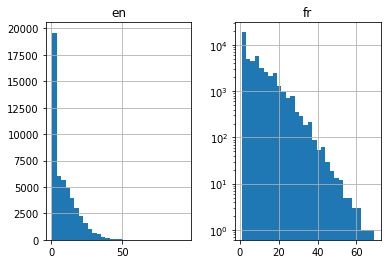

In [14]:
length_df.hist(bins = 30)
plt.yscale('log',basey=10) 
plt.show()

Let's vectorize our text data by using Keras's Tokenizer() class. It will turn our sentences into sequences of integers. Then we will pad those sequences with zeros to make all the sequences of same length.

In [15]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [16]:
# prepare english tokenizer
eng_tokenizer = tokenization(en_fr[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 17188


In [17]:
# prepare French tokenizer
fr_tokenizer = tokenization(en_fr[:, 1])
fr_vocab_size = len(fr_tokenizer.word_index) + 1

fr_length = 8
print('French Vocabulary Size: %d' % fr_vocab_size)

French Vocabulary Size: 22552


In [18]:
print(fr_tokenizer.word_counts)

OrderedDict([('hansard', 42), ('révisé', 44), ('numéro', 52), ('1', 100), ('le', 15525), ('lundi', 14), ('22', 18), ('septembre', 34), ('1997', 70), ('première', 243), ('session36e', 2), ('législature', 56), ('ouverture', 5), ('du', 5762), ('parlement', 124), ('greffier', 14), ('de', 21202), ('la', 12432), ('chambre', 821), ('élection', 54), ('président', 584), ('délection', 19), ('suspension', 11), ('séance', 50), ('reprise', 74), ('session', 9), ('chambres', 6), ('des', 7989), ('communes', 98), ('trentecinquième', 1), ('ayant', 54), ('été', 945), ('prorogée', 1), ('et', 6823), ('les', 9944), ('dissoutes', 1), ('par', 1499), ('proclamation', 2), ('dimanche', 4), ('27', 11), ('avril', 19), ('199', 330), ('convoqué', 3), ('pour', 3918), ('aujourdhu', 248), ('gentilhomme', 4), ('huissier', 2), ('verge', 2), ('noire', 3), ('apporte', 13), ('message', 50), ('suivan', 7), ('membres', 139), ('commune', 74), ('cest', 1827), ('désir', 12), ('lhonorable', 71), ('suppléant', 111), ('son', 740), 

Given below is a function to prepare the sequences. It will also perform sequence padding to a maximum sentence length as mentioned above. 

In [19]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    print(seq)
    print(len(seq))
    return seq

### Model Building

We will now split the data into train and test set for model training and evaluation, respectively.

In [20]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(en_fr, test_size=0.2, random_state = 12)

It's time to encode the sentences. We will encode German sentences as the input sequences and English sentences as the target sequences. It will be done for both train and test datasets.

In [21]:
# prepare training data
trainX = encode_sequences(fr_tokenizer, fr_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

[[   39   431 19647 ...   158    55 12053]
 [19998     7    57 ...    28     4   105]
 [   12   389     0 ...     0     0     0]
 ...
 [16523 11107   150 ...     1     3   675]
 [  582     0     0 ...     0     0     0]
 [   54   279   458 ...     0     0     0]]
40000
[[   62    77     5 ...    76    54   171]
 [  623     1 10023 ...    27    19    50]
 [    9  2340     0 ...     0     0     0]
 ...
 [13157     0     0 ...     0     0     0]
 [  222     0     0 ...     0     0     0]
 [    8   185   285 ...     4    35   145]]
40000


In [22]:
print(trainX.shape)
print(trainY.shape)

(40000, 8)
(40000, 8)


In [23]:
# prepare validation data
testX = encode_sequences(fr_tokenizer, fr_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

[[  223     0     0 ...     0     0     0]
 [   50     3   391 ...     0     0     0]
 [    3   250  6710 ...     0     0     0]
 ...
 [10642    24  7014 ...     0     0     0]
 [  100    49  4892 ...   204     6  3541]
 [   14    36     6 ...    31   120  5619]]
10000
[[ 210    0    0 ...    0    0    0]
 [  48   60    0 ...    0    0    0]
 [4711 5952    0 ...    0    0    0]
 ...
 [   9  538   13 ...    0    0    0]
 [  17   20 1511 ...   82    1  360]
 [  38   44   77 ...   16  353  661]]
10000


In [24]:
print(testX.shape)
print(testY.shape)

(10000, 8)
(10000, 8)


Now comes the exciting part! Let us define our Seq2Seq model architecture. We are using an Embedding layer and an LSTM layer as our encoder and another LSTM layer followed by a Dense layer as the decoder.  

In [25]:
# build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))    
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

Details about the RepeatVector :  https://campus.datacamp.com/courses/machine-translation-in-python/implementing-an-encoder-decoder-model-with-keras?ex=6

We are using RMSprop optimizer in this model as it is usually a good choice for recurrent neural networks.

In [26]:
print(fr_vocab_size)
print(eng_vocab_size)
print(fr_length)
print(eng_length)

22552
17188
8
8


In [27]:
model = build_model(fr_vocab_size, eng_vocab_size, fr_length, eng_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

Please note that we have used __'sparse_categorical_crossentropy'__ as the loss function because it allows us to use the target sequence as it is instead of one hot encoded format. One hot encoding the target sequences with such a huge vocabulary might consume our system's entire memory.

It seems we are all set to start training our model. We will train it for 30 epochs and with a batch size of 512. You may change and play these hyperparameters. We will also be using __ModelCheckpoint()__ to save the best model with lowest validation loss. I personally prefer this method over early stopping.

In [28]:
filename = 'model.h1.05_may_20'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=30, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

Train on 32000 samples, validate on 8000 samples
Epoch 1/30
32000/32000 [==============================] - 264s 8ms/step - loss: 5.6230 - val_loss: 5.1041

Epoch 00001: val_loss improved from inf to 5.10407, saving model to model.h1.05_may_20
Epoch 2/30
32000/32000 [==============================] - 260s 8ms/step - loss: 4.9001 - val_loss: 4.8398

Epoch 00002: val_loss improved from 5.10407 to 4.83985, saving model to model.h1.05_may_20
Epoch 3/30
32000/32000 [==============================] - 255s 8ms/step - loss: 4.7063 - val_loss: 4.7379

Epoch 00003: val_loss improved from 4.83985 to 4.73792, saving model to model.h1.05_may_20
Epoch 4/30
32000/32000 [==============================] - 262s 8ms/step - loss: 4.6044 - val_loss: 4.6748

Epoch 00004: val_loss improved from 4.73792 to 4.67482, saving model to model.h1.05_may_20
Epoch 5/30
32000/32000 [==============================] - 243s 8ms/step - loss: 4.5364 - val_loss: 4.6263

Epoch 00005: val_loss improved from 4.67482 to 4.62628, 

Let's compare the training loss and the validation loss.

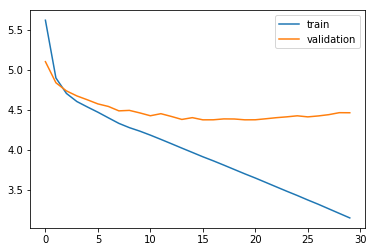

In [39]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

### Make Predictions

Let's load the saved model to make predictions.

In [40]:
model = load_model('model.h1.05_may_20')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

In [41]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [42]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [43]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [44]:
pd.set_option('display.max_colwidth', 200)

In [45]:
pred_df.head(15)

,actual,predicted
0,finance,
1,if no,i am the
2,hybrid turkeys,the
3,m,m
4,international trade,health
5,they have seen destructive dynamics at work in the past and they are finally seeing government turning the corner and starting to see the reduction of deficit and low interest rate,the
6,some ho,some ho
7,i point this out not as a hypothetical case because according to that memorandum a pilot project has been initiate,i that the
8,m,m
9,we have heard a lot about this millennium fund and that somehow it is a wonderful thing that will happen in the year 2000 to help young peopl,the canad


In [46]:
pred_df.tail(15)

,actual,predicted
9985,this is a great price for them and their families to pa,the countr
9986,this petition reads as followsi shall summarize because it is rather lon,we is the
9987,my ho,i the
9988,one may wonder why the ministe,the
9989,m,m
9990,believe m,that is the
9991,fortyfive per cent of motor vehicle collision,it is the
9992,during this next mandat,the year
9993,its quite lega,it is
9994,m,m


In [47]:
pred_df.tail(15)

,actual,predicted
9985,this is a great price for them and their families to pa,the countr
9986,this petition reads as followsi shall summarize because it is rather lon,we is the
9987,my ho,i the
9988,one may wonder why the ministe,the
9989,m,m
9990,believe m,that is the
9991,fortyfive per cent of motor vehicle collision,it is the
9992,during this next mandat,the year
9993,its quite lega,it is
9994,m,m


In [48]:
pred_df.sample(15)

,actual,predicted
5886,,m
7500,the reform of the health care syste,the
3069,we have been very specific on this issue and every other issu,to the i
6476,the government blames the railway,the
5635,,m
549,the canada pension trust needs to be completely independent from the government of the day if it is to wor,in
2718,m,m
9664,procedure and house affairs,procedure and house affairs
881,transitional job creation fund,canada and
9832,m,m


Despues de bastante trastear con el tratado de datos previo no he conseguido nada parecio a algo razonable :(
Asi que vamos a probar con el dataset español - inglés

In [8]:
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text

In [9]:
data = read_text("data_traductor\spa.txt")
spa_eng = to_lines(data)
spa_eng = array(spa_eng)

In [10]:
spa_eng = spa_eng[:50000,:]

In [11]:
spa_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in spa_eng[:,0]]
spa_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in spa_eng[:,1]]

In [12]:
# convert to lowercase
for i in range(len(spa_eng)):
    spa_eng[i,0] = spa_eng[i,0].lower()
    
    spa_eng[i,1] = spa_eng[i,1].lower()

In [13]:
eng_l = []
spa_l = []

# populate the lists with sentence lengths
for i in spa_eng[:,0]:
    eng_l.append(len(i.split()))

for i in spa_eng[:,1]:
    spa_l.append(len(i.split()))

In [14]:
length_df = pd.DataFrame({'eng':eng_l, 'spa':spa_l})

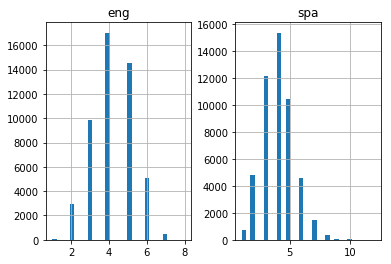

In [15]:
length_df.hist(bins = 30)
plt.show()

In [47]:
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [48]:
eng_tokenizer = tokenization(spa_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 6942


In [49]:
spa_tokenizer = tokenization(spa_eng[:, 1])
spa_vocab_size = len(spa_tokenizer.word_index) + 1

spa_length = 8
print('Spanish Vocabulary Size: %d' % spa_vocab_size)

Spanish Vocabulary Size: 14196


In [50]:
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    print(seq)
    print(len(seq))
    return seq

In [51]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(spa_eng, test_size=0.2, random_state = 12)

In [59]:
trainX = encode_sequences(spa_tokenizer, spa_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

[[   1   10 1574 ...    0    0    0]
 [4836    4    6 ...    0    0    0]
 [  14 4963    0 ...    0    0    0]
 ...
 [  43  199 1665 ...    0    0    0]
 [  18   12   15 ...    8 1196    0]
 [   2  240 1475 ...    0    0    0]]
40000
[[   3  182   10 ...    0    0    0]
 [   1 1094    6 ...    0    0    0]
 [  50  101    9 ...    0    0    0]
 ...
 [  44  444  432 ...    0    0    0]
 [  22    4  123 ...  213    0    0]
 [   1  202 2244 ...    0    0    0]]
40000


In [60]:
print(trainX.shape)
print(trainY.shape)

testX = encode_sequences(spa_tokenizer, spa_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

print(testX.shape)
print(testY.shape)

(40000, 8)
(40000, 8)
[[  53   43   28 ...    0    0    0]
 [ 233    4    1 ...    0    0    0]
 [ 108 8599    0 ...    0    0    0]
 ...
 [9604  115  974 ...    0    0    0]
 [1347   55  598 ...    0    0    0]
 [   2   31 6750 ...    0    0    0]]
10000
[[  36   16   40 ...    0    0    0]
 [   1   37    3 ...    0    0    0]
 [   2   99 1339 ...    0    0    0]
 ...
 [  56 1781   29 ...    0    0    0]
 [  33    2  217 ...    0    0    0]
 [   1  867   42 ...    0    0    0]]
10000
(10000, 8)
(10000, 8)


In [61]:
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))    
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [62]:
model = build_model(spa_vocab_size, eng_vocab_size, spa_length, eng_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [63]:
filename = 'model.h1.8_may_20'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=30, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

Train on 32000 samples, validate on 8000 samples
Epoch 1/30
32000/32000 [==============================] - 137s 4ms/step - loss: 3.9646 - val_loss: 3.3454

Epoch 00001: val_loss improved from inf to 3.34539, saving model to model.h1.8_may_20
Epoch 2/30
32000/32000 [==============================] - 139s 4ms/step - loss: 3.2609 - val_loss: 3.2427

Epoch 00002: val_loss improved from 3.34539 to 3.24272, saving model to model.h1.8_may_20
Epoch 3/30
32000/32000 [==============================] - 142s 4ms/step - loss: 3.1086 - val_loss: 3.1009

Epoch 00003: val_loss improved from 3.24272 to 3.10087, saving model to model.h1.8_may_20
Epoch 4/30
32000/32000 [==============================] - 142s 4ms/step - loss: 2.9714 - val_loss: 3.0243

Epoch 00004: val_loss improved from 3.10087 to 3.02433, saving model to model.h1.8_may_20
Epoch 5/30
32000/32000 [==============================] - 143s 4ms/step - loss: 2.8317 - val_loss: 2.8595

Epoch 00005: val_loss improved from 3.02433 to 2.85952, savi

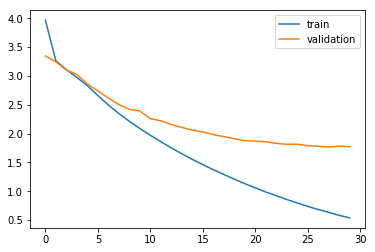

In [64]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [65]:
model = load_model('model.h1.8_may_20')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

In [66]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [67]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [68]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [69]:
pd.set_option('display.max_colwidth', 200)

In [70]:
pred_df.head(15)

,actual,predicted
0,they are very cheerful,theyre very
1,i know tom,i know tom
2,you may refuse,you may win
3,thats private,thats is
4,tom leaped from his seat,tom put on his
5,have you ever sold a car,let you ever a car
6,how many kids do you have,how many do have
7,i will not let you do it,i will do you
8,isnt it beautiful,isnt it beautiful
9,my parrot died yesterday,my dog died me


In [71]:
pred_df.tail(15)

,actual,predicted
9985,do tom and mary know,does tom mary
9986,tom can be clumsy,tom cant be useful
9987,do you want to try it,do you want to try it
9988,do you know who he was,do you know who he was
9989,shes also a beauty,its a serious
9990,i love your daughter,i want your opinion
9991,he teaches english,he began to english
9992,i overslept,i was asleep
9993,he is as poor as can be,he is as poor
9994,wheres my shirt,wheres my


Con este dataset si obtenemos unos resultados razonables